In [449]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import math
import plotly.express as px
from fitter import Fitter, get_common_distributions, get_distributions

In [450]:
data = pd.read_csv('model_data.csv')
data['PO_Document_Date'] = pd.to_datetime(data['PO_Document_Date'] , format='%Y-%m-%d')

In [451]:
data['days_late'] = np.where(data['days_late']>0, data['days_late'], 0)
data = data[data['days_late'] < 25]

In [452]:
(data.groupby('Material_Group').agg('nunique')['PO_Number']).sort_values(ascending=False)

Material_Group
013     5413
073     3663
060     2504
018     2447
017     1918
057     1493
012     1316
032      906
048      791
030      789
041      464
014      458
059      444
040      362
009      350
021      330
002      216
X714     214
X709     187
X711     187
001      136
056      121
047      110
054       92
008       76
X722      65
098       57
X713      54
005       53
010       43
011       37
X706      32
X704      25
X703      19
X725      17
X707      16
X727      10
X715       9
027        8
X712       7
X701       6
X717       6
X721       6
X708       5
061        3
080        2
X726       1
Name: PO_Number, dtype: int64

In [497]:
def joint_distributions(input_data :pd.DataFrame, mg : str, increment_size):
    mg_dat = input_data[input_data['Material_Group']==mg]
    mg_dat['days_late'] = pd.to_numeric(mg_dat['days_late'])
    grouped = mg_dat.groupby('Vendor_number').resample('M', on='PO_Document_Date')
    late_p = grouped.mean()['days_late'].reset_index()

    dates = list(late_p['PO_Document_Date'].unique())
    MVEF_Ingest = pd.DataFrame({'Month': dates})
    keep_columns = ['Month']
    perf_columns = []
    for Vendor_number in set(late_p['Vendor_number']):
        sup_data = late_p[late_p['Vendor_number'] == Vendor_number][['PO_Document_Date', 'days_late']]
        non_nulls = [x for x in sup_data['days_late'] if x > -1000]
        if late_p[late_p['Vendor_number'] == Vendor_number]['days_late'].count() < 12:
            continue
        sup_data = sup_data.rename(
            columns={'days_late': f'{Vendor_number} days_late', 'PO_Document_Date': f'{Vendor_number}_date'})
        keep_columns.append(f'{Vendor_number} days_late')
        perf_columns.append(f'{Vendor_number} days_late')
        MVEF_Ingest = pd.merge(MVEF_Ingest, sup_data, how='left', left_on='Month', right_on=f'{Vendor_number}_date')
    # keep_columns = ['Month','539861 days_late','566041 days_late','505439 days_late']
    # perf_columns = ['539861 days_late','566041 days_late','505439 days_late']
    MVEF_Ingest = MVEF_Ingest[keep_columns]
    MVEF_Clean = MVEF_Ingest[perf_columns].interpolate(method='linear', axis=0, limit_direction='forward')
    MVEF_Clean['Month'] = MVEF_Ingest['Month']
    MVEF_Clean = MVEF_Clean.dropna()
    return MVEF_Clean
MVEF_Clean = joint_distributions(input_data=data, mg='017', increment_size=.1)

#     MVEF_Clean = MVEF_Clean[keep_columns]
#     MVEF_Clean = MVEF_Clean.sort_values(['Month'], ascending=True)
#
#     actual_weights = mg_dat.groupby('Vendor_number').agg('nunique')[['PO_Number']]
#     # actual_weights = actual_weights / actual_weights.sum()
#     actual_weights = actual_weights.transpose()
#     ac_suppliers = actual_weights.columns
#     change_dic = {}
#     for sup in ac_suppliers:
#         change_dic[sup] = str(sup) + ' days_late'
#     actual_weights = actual_weights.rename(columns=change_dic)
#     actual_weights = actual_weights[perf_columns]
#     actual_weights = actual_weights.transpose()
#     actual_weights = actual_weights / actual_weights.sum()
#     actual_weights = actual_weights.transpose()
#     actual_weights = actual_weights.round(2)
#
#     binned_frame = pd.DataFrame()
#     for supplier in perf_columns:
#         binned_frame[f'{supplier}'] = np.where(MVEF_Clean[f'{supplier}'] <= 0, 0,
#                                         np.where(
#                                             (MVEF_Clean[f'{supplier}'] > 0) & (MVEF_Clean[f'{supplier}'] <= 2), 1,
#                                         np.where(
#                                             MVEF_Clean[f'{supplier}'] > 2, 2, 'FLAG: BINNING ERROR'
#                                             )
#                                         )
#                                     )
#         binned_frame[f'{supplier}'] = pd.to_numeric(binned_frame[f'{supplier}'])
#     # fig, ax = plt.subplots(nrows=1, ncols=len(perf_columns), figsize=(15, 6))
#     # for index, supplier in enumerate(perf_columns):
#     #     plot = sns.histplot(
#     #         data=binned_frame[supplier],
#     #         kde=False,
#     #         element='step',
#     #         ax=ax[index],
#     #         bins=[0,1,2,3],
#     #         stat='density',
#     #         label='Actual',
#     #         color='Green'
#     #     )
#     #     plot.set_xlabel('Days Late')
#     #     Name = supplier.split()[0] + ' ' +supplier.split()[1]
#     #     plot.set_title(f'{Name}')
#     #     plt.tight_layout()
#     binned_frame['Prob_Counter'] = 1
#     joint_prob = binned_frame.groupby(perf_columns).agg('count')['Prob_Counter'].reset_index()
#     joint_prob['Probability'] = joint_prob['Prob_Counter'] / sum(joint_prob['Prob_Counter'])
#     return joint_prob, perf_columns, actual_weights, MVEF_Clean
# joint_dist, perf_columns, actual_weights, MVEF_Clean = joint_distributions(input_data=data, mg='017', increment_size=.1)

/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/1277909378.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [462]:
MVEF_Clean

,Month,539850 days_late,578425 days_late,539861 days_late,566041 days_late,505439 days_late
43,2018-12-31,5.000000,0.000000,0.0,0.000000,0.130435
44,2019-01-31,5.000000,0.000000,0.0,0.000000,0.130435
25,2021-03-31,0.000000,1.217391,0.0,0.000000,0.312500
26,2021-04-30,2.666667,1.379310,0.0,0.000000,1.894737
27,2021-05-31,0.000000,2.900000,0.0,1.000000,3.333333
28,2021-06-30,0.000000,0.833333,0.0,0.166667,6.606061
29,2021-07-31,0.000000,4.111111,0.0,0.000000,4.076923
30,2021-08-31,1.555556,4.642857,0.0,0.000000,9.294118
31,2021-09-30,3.111111,0.214286,0.0,0.000000,3.612903
32,2021-10-31,4.666667,0.000000,0.0,0.000000,5.160000


In [463]:
def weighted_portfolios(columns, increment_size):
    # Function to create weight combinations to test
    increments = []
    n = 0
    while n < .99:
        increments.append(round(n,3))
        n += increment_size
    increments = increments + (increments[0:math.ceil(len(increments)/2)] * (len(columns)-1))
    possible_combinations = itertools.permutations(increments, len(columns))
    # print(list(possible_combinations)[:100])
    subsets = set()
    for subset in tqdm(possible_combinations):
        if sum(subset) == 1:
            subsets.add(subset)
    weights = {}
    for index, column in enumerate(columns):
        weights[column] = [x[index] for x in subsets]
    w_martrix = pd.DataFrame(weights)
    return w_martrix
weights = weighted_portfolios(columns=perf_columns,#['539861 days_late','566041 days_late','505439 days_late'],
                              increment_size=.1)

17100720it [00:06, 2626661.61it/s]


In [464]:
def weighted_dist(weights, joint_distribution, columns, actual_weights):
    distribution_indexer = {}
    distribution_dicts = {}
    for index, weight in weights.iterrows():
        weighted_distribution = joint_distribution[columns] * weight
        weighted_distribution['Z'] = weighted_distribution.sum(axis=1)
        weighted_distribution['Probability'] = joint_distribution['Probability']
        weighted_distribution['E[Z]'] = weighted_distribution['Probability'] * weighted_distribution['Z']
        weighted_distribution['E[Z^2]'] = weighted_distribution['Probability'] * (weighted_distribution['Z']**2)
        mean = sum(weighted_distribution['E[Z]'])
        variance = weighted_distribution['E[Z^2]'].sum() - weighted_distribution['E[Z]'].sum() **2
        distribution_indexer[index] = mean #* (variance**(1/2))
        distribution_dicts[index] = weighted_distribution
    for index, weight in actual_weights.iterrows():
        actual_weighted_distribution = joint_distribution[columns] * weight
        actual_weighted_distribution['Z'] = actual_weighted_distribution.sum(axis=1)
        actual_weighted_distribution['Probability'] = joint_distribution['Probability']
    return distribution_indexer, distribution_dicts, actual_weighted_distribution
dist_indexer, dist_dics, actual_weighted_distribution = weighted_dist(weights=weights, joint_distribution=joint_dist, columns = perf_columns, actual_weights=actual_weights)
# ['539861 days_late','566041 days_late','505439 days_late'] )

In [465]:
actual_weights

Vendor_number,539850 days_late,578425 days_late,539861 days_late,566041 days_late,505439 days_late
PO_Number,0.02,0.13,0.09,0.11,0.65


In [540]:
def best_option(dist_indexer, dist_dics, actual_weighted_distribution):
    best_dist = [index for index in dist_indexer.keys() if dist_indexer[index]==min(dist_indexer.values())][0]
    df = dist_dics[best_dist].groupby('Z').sum()[['Probability']].reset_index()
    df['Z'] = df['Z'].round(2)
    for value in range(0,21):
        actual = value/10
        if actual not in list(df['Z']):
            df_add = pd.DataFrame({"Z":[actual],
                        "Probability":[0]
                        })
            df = pd.concat([df, df_add])
    df['Distribution'] = 'Suggested Supplier Mix'
    df2 = actual_weighted_distribution.groupby('Z').sum()[['Probability']].reset_index()
    df2['Z'] = df2['Z'].round(2)
    for value in range(0,21):
        actual = value/10
        if float(actual) not in list(df2['Z']):
            df2_add = pd.DataFrame({"Z":[actual],
                        "Probability":[0]
                        })
            df2 = pd.concat([df2, df2_add])
    df2 = df2.drop_duplicates(subset = ['Z'], keep = 'first')
    df2['Distribution'] = 'Actual Supplier Mix'
    main = pd.concat([df, df2])
    main = main.sort_values(['Z'])
    fig = px.area(main[main['Distribution']=='Actual Supplier Mix'],
                  x="Z",
                  y="Probability",
                  # color='Distribution',
                  color_discrete_sequence=['steelblue',],
                  title="Probability Distribution of Average Order Lateness",
                  line_shape='hvh'
                  )
    fig.update_layout(
        xaxis_title="Average Order Lateness",
        yaxis_title='Probability Density',
        font=dict(
        family="Arial",
        size=20,
        color='#000000'),
        width=900, height=900)
    plt.tight_layout()
    plt.savefig('eg_fig.png')
    return fig
best_option(dist_indexer=dist_indexer, dist_dics=dist_dics, actual_weighted_distribution=actual_weighted_distribution)

<Figure size 640x480 with 0 Axes>

In [437]:
def validator_extreme(mg, dist_indexer, MVEF_Clean, input_data, weights, perf_columns, cutoff_date):
    # Validate the methodology extremely
    mg_dat = input_data[input_data['Material_Group']==mg]
    mg_dat['days_late'] = pd.to_numeric(mg_dat['days_late'])
    grouped = mg_dat.resample('M', on='PO_Document_Date').mean()['days_late'].reset_index()

    grouped[f'Bins'] = np.where(grouped['days_late'] <= 0, 0,
                                np.where(
                                    (grouped['days_late'] > 0) & (grouped['days_late'] <= 2), 1,
                                np.where(
                                    grouped['days_late'] > 2, 2, 'FLAG: BINNING ERROR'
                                    )
                                )
                            )
    grouped = grouped.rename(columns={'PO_Document_Date':"Month",
                                      'days_late':'Average Days Late'
                                      })
    grouped['Label'] = 'Actual Supplier Mix'
    best_dist = [index for index in dist_indexer.keys() if dist_indexer[index]==min(dist_indexer.values())][0]
    best_weights = weights.loc[best_dist]
    print(best_weights)
    best_performance = MVEF_Clean[perf_columns] * best_weights
    best_performance['Month'] = MVEF_Clean['Month']
    best_performance['Average Days Late'] = best_performance[perf_columns].sum(axis=1)
    best_performance['Label'] = 'Recommended Supplier Mix'
    best_performance = best_performance[best_performance['Month']>=cutoff_date]

    main = pd.concat([grouped, best_performance])

    grouped2 = mg_dat.resample('M', on='PO_Document_Date').nunique()['PO_Number'].reset_index()
    main = pd.merge(main, grouped2, how='left', left_on='Month', right_on='PO_Document_Date')
    main['Total Late Days'] = main['Average Days Late'] * main['PO_Number']

    interim = main[main['Month']>=cutoff_date]
    details = interim.groupby('Label').agg('mean')[['Total Late Days']]

    # return details
    details_frame = pd.DataFrame({
        'MG':[mg],
        'Date':[cutoff_date],
        'Recommended Avg. Monthly Total Days Late': details['Total Late Days'].loc['Recommended Supplier Mix'],
        'Actual Avg. Monthly Total Days Late': details['Total Late Days'].loc['Actual Supplier Mix'],
    })

    fig = px.line(main,
                  x="Month",
                  y="Total Late Days",
                  color = 'Label',
                  title="Marginal improvement of using recommended supplier mix",
                  )

    fig.update_layout(
        # xaxis_title="Average Order Cost",
        width=1200, height=600)
    fig.add_vline(x=cutoff_date)

    return fig, details_frame

# USE ALL DATA AS INPUT DATA HERE
cutoff_date = pd.to_datetime('2021-09-01', format='%Y-%m-%d')
validator_extreme(mg = '017',
                  dist_indexer = dist_indexer,
                  MVEF_Clean = MVEF_Clean,
                  input_data = data,
                  weights = weights,
                  perf_columns = perf_columns,
                  cutoff_date = cutoff_date
                  )

539850 days_late    0.0
578425 days_late    0.0
539861 days_late    0.9
566041 days_late    0.1
505439 days_late    0.0
Name: 530, dtype: float64


/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/3027358990.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(Figure({
     'data': [{'hovertemplate': 'Label=Actual Supplier Mix<br>Month=%{x}<br>Total Late Days=%{y}<extra></extra>',
               'legendgroup': 'Actual Supplier Mix',
               'line': {'color': '#636efa', 'dash': 'solid'},
               'marker': {'symbol': 'circle'},
               'mode': 'lines',
               'name': 'Actual Supplier Mix',
               'orientation': 'v',
               'showlegend': True,
               'type': 'scatter',
               'x': array([datetime.datetime(2018, 12, 31, 0, 0),
                           datetime.datetime(2019, 1, 31, 0, 0),
                           datetime.datetime(2019, 2, 28, 0, 0),
                           datetime.datetime(2019, 3, 31, 0, 0),
                           datetime.datetime(2019, 4, 30, 0, 0),
                           datetime.datetime(2019, 5, 31, 0, 0),
                           datetime.datetime(2019, 6, 30, 0, 0),
                           datetime.datetime(2019, 7, 31, 0, 0),
           

In [483]:
def compiler(increment_size, mg, cutoff_date):
    # CUT OFF DATE FOR VALIDATION EXCEPT ON VALIDATOR

    # Parameters
    # increment_size = .1
    # mg = '013'
    # cutoff_date = pd.to_datetime('2021-10-01', format='%Y-%m-%d')

    # Clean Data
    data = pd.read_csv('model_data.csv')
    data['PO_Document_Date'] = pd.to_datetime(data['PO_Document_Date'] , format='%Y-%m-%d')
    data['days_late'] = np.where(data['days_late']>0, data['days_late'], 0)
    data = data[data['days_late'] < 25]

    input_data = data[data['PO_Document_Date'] < cutoff_date]

    # Find Joint Distribution
    joint_dist, perf_columns, actual_weights, MVEF_Clean = joint_distributions(input_data=input_data, mg=mg, increment_size=increment_size)
    # Get updated results
    joint_dist2, perf_columns2, actual_weights2, MVEF_Clean2 = joint_distributions(input_data=data, mg=mg, increment_size=increment_size)
    # Create Weights
    weights = weighted_portfolios(columns=perf_columns, increment_size=increment_size)
    if len(perf_columns) == 1:
        weights2 = pd.DataFrame({perf_columns[0]:[1]})
        weights = pd.concat([weights, weights2])
    # Build Distributions
    dist_indexer, dist_dics, actual_weighted_distribution = weighted_dist(weights=weights, joint_distribution=joint_dist, columns = perf_columns, actual_weights=actual_weights)
    best_dist = [index for index in dist_indexer.keys() if dist_indexer[index]==min(dist_indexer.values())][0]
    recommended_weights = weights.loc[best_dist]
    # Find Best Weights And Compare to Actual Weights
    distributions_fig = best_option(dist_indexer=dist_indexer, dist_dics=dist_dics, actual_weighted_distribution=actual_weighted_distribution)
    # Validate Methodology
    valid_fig, details = validator_extreme(mg = mg,
                  dist_indexer = dist_indexer,
                  MVEF_Clean = MVEF_Clean2,
                  input_data = data,
                  weights = weights,
                  perf_columns = perf_columns,
                  cutoff_date = cutoff_date
                  )
    return valid_fig, details, distributions_fig, recommended_weights
valid_fig, details, distributions_fig, recommended_weights, MVEF_Clean2 = compiler(increment_size=.1,
                                                                      mg='017',
                                                                      cutoff_date=pd.to_datetime('2022-08-01', format='%Y-%m-%d')
                                                                        )
recommended_weights

/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/3245379082.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/3245379082.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

17100720it [00:06, 2679474.02it/s]


539850 days_late    0.0
578425 days_late    0.0
539861 days_late    0.9
566041 days_late    0.1
505439 days_late    0.0
Name: 530, dtype: float64


/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/3027358990.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ValueError: not enough values to unpack (expected 5, got 4)

<Figure size 640x480 with 0 Axes>

In [419]:
valid_fig, details, distributions_fig, recommended_weights, MVEF_Clean2 = compiler(increment_size=.1,
                                                                      mg='017',
                                                                      cutoff_date=pd.to_datetime('2021-08-01', format='%Y-%m-%d')
                                                                        )

/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/3245379082.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/3245379082.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

303600it [00:00, 2280803.24it/s]


539850 days_late    0.4
539861 days_late    0.6
566041 days_late    0.0
505439 days_late    0.0
Name: 99, dtype: float64


/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/2290122452.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 640x480 with 0 Axes>

In [420]:
recommended_weights

539850 days_late    0.4
539861 days_late    0.6
566041 days_late    0.0
505439 days_late    0.0
Name: 99, dtype: float64

In [416]:
MVEF_Clean2

,Month,539850 days_late,578425 days_late,539861 days_late,566041 days_late,505439 days_late
43,2018-12-31,5.000000,0.000000,0.0,0.000000,0.130435
44,2019-01-31,5.000000,0.000000,0.0,0.000000,0.130435
25,2021-03-31,0.000000,1.217391,0.0,0.000000,0.312500
26,2021-04-30,2.666667,1.379310,0.0,0.000000,1.894737
27,2021-05-31,0.000000,2.900000,0.0,1.000000,3.333333
28,2021-06-30,0.000000,0.833333,0.0,0.166667,6.606061
29,2021-07-31,0.000000,4.111111,0.0,0.000000,4.076923
30,2021-08-31,1.555556,4.642857,0.0,0.000000,9.294118
31,2021-09-30,3.111111,0.214286,0.0,0.000000,3.612903
32,2021-10-31,4.666667,0.000000,0.0,0.000000,5.160000


In [421]:
valid_fig

In [422]:
details

,MG,Date,Recommended Avg. Monthly Total Days Late,Actual Avg. Monthly Total Days Late
0,017,2021-08-01,81.870085,71.729974


In [526]:
distributions_fig

In [280]:
recommended_weights

569547 days_late    0.9
561549 days_late    0.1
522865 days_late    0.0
Name: 20, dtype: float64

In [443]:
# import tqdm
def master_compiler_extreme():
    mgs = [
        '017',
    ]
    cutoffs = [
        # '2021-05-01',
        # '2021-06-01',
        # '2021-07-01',
        # '2021-08-01',
        '2021-09-01',
        # '2021-10-01',
    ]
    cutoffs = [pd.to_datetime(x, format='%Y-%m-%d') for x in cutoffs]
    mg_dic = {}
    details_frame = pd.DataFrame({
        'MG':[],
        'Date':[],
        'Recommended Avg. Monthly Total Days Late': [],
        'Actual Avg. Monthly Total Days Late': [],
    })
    for mg in mgs:
        print(mg)
        stored_figs = {}
        stored_weights = {}
        for cutoff_date in cutoffs:
            valid_fig, details, distributions_fig, recommended_weights = compiler(increment_size=.1, mg=mg, cutoff_date=cutoff_date)
            stored_figs[cutoff_date] = valid_fig
            details_frame = pd.concat([details_frame,details])
            stored_weights[cutoff_date] = recommended_weights
        mg_dic[mg] = {'Validation':stored_figs,
                  'Weights':stored_weights
                  }
    return mg_dic, details_frame

In [444]:
results, details_frames = master_compiler_extreme()

017


/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/3245379082.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/3245379082.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

303600it [00:00, 2380356.39it/s]


539850 days_late    0.1
539861 days_late    0.9
566041 days_late    0.0
505439 days_late    0.0
Name: 15, dtype: float64


/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_10990/3027358990.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 640x480 with 0 Axes>

In [445]:
details_frames['Margins'] = details_frames['Actual Avg. Monthly Total Days Late'] - details_frames['Recommended Avg. Monthly Total Days Late']
details_frames
# details_frames.to_csv('details2.csv')

,MG,Date,Recommended Avg. Monthly Total Days Late,Actual Avg. Monthly Total Days Late,Margins
0,017,2021-09-01,21.39537,46.066847,24.671477


In [311]:
mgs = [
    '073',
    '013',
    '017'
]
cutoffs = [
    '2021-05-01',
    '2021-06-01',
    '2021-07-01',
    '2021-08-01',
    '2021-09-01',
    '2021-10-01',
]
for mg in mgs:
    for cutoff_date in cutoffs:
        print(mg, cutoff_date)
        print(results[mg]['Details'][pd.to_datetime(cutoff_date, format='%Y-%m-%d')])

073 2021-05-01
                          Total Late Days
Label                                    
Actual Supplier Mix            169.761803
Recommended Supplier Mix       119.693992
073 2021-06-01
                          Total Late Days
Label                                    
Actual Supplier Mix            165.488912
Recommended Supplier Mix        56.289896
073 2021-07-01
                          Total Late Days
Label                                    
Actual Supplier Mix            154.247736
Recommended Supplier Mix        55.696692
073 2021-08-01
                          Total Late Days
Label                                    
Actual Supplier Mix            145.131042
Recommended Supplier Mix        54.949225
073 2021-09-01
                          Total Late Days
Label                                    
Actual Supplier Mix            103.014021
Recommended Supplier Mix        52.944355
073 2021-10-01
                          Total Late Days
Label                       

In [313]:
results

{'073': {'Validation': {Timestamp('2021-05-01 00:00:00'): Figure({
       'data': [{'hovertemplate': 'Label=Actual Supplier Mix<br>Month=%{x}<br>Total Late Days=%{y}<extra></extra>',
                 'legendgroup': 'Actual Supplier Mix',
                 'line': {'color': '#636efa', 'dash': 'solid'},
                 'marker': {'symbol': 'circle'},
                 'mode': 'lines',
                 'name': 'Actual Supplier Mix',
                 'orientation': 'v',
                 'showlegend': True,
                 'type': 'scatter',
                 'x': array([datetime.datetime(2019, 2, 28, 0, 0),
                             datetime.datetime(2019, 3, 31, 0, 0),
                             datetime.datetime(2019, 4, 30, 0, 0),
                             datetime.datetime(2019, 5, 31, 0, 0),
                             datetime.datetime(2019, 6, 30, 0, 0),
                             datetime.datetime(2019, 7, 31, 0, 0),
                             datetime.datetime(2019, 8,

In [348]:
time = pd.to_datetime('2021-09-01', format='%Y-%m-%d')
results['017']['Validation'][time]

In [53]:
best_dist = [index for index in dist_indexer.keys() if dist_indexer[index]==min(dist_indexer.values())][0]

In [60]:
dist_dics[best_dist].groupby('Z').sum()[['Probability']].reset_index()

,Z,Probability
0,0.0,0.75
1,0.1,0.25


In [55]:
weights.loc[best_dist]

539850 days_late    0.0
578425 days_late    0.0
539861 days_late    0.9
566041 days_late    0.1
505439 days_late    0.0
Name: 530, dtype: float64

In [63]:
dist_dics[0]

,539850 days_late,578425 days_late,539861 days_late,566041 days_late,505439 days_late,Z,Probability,E[Z],E[Z^2]
0,0.0,0.0,0.0,0.0,0.4,0.4,0.05,0.020,0.0080
1,0.0,0.1,0.0,0.0,0.4,0.5,0.05,0.025,0.0125
2,0.0,0.1,0.0,0.0,0.8,0.9,0.05,0.045,0.0405
3,0.0,0.1,0.0,0.0,0.4,0.5,0.05,0.025,0.0125
4,0.0,0.1,0.0,0.0,0.8,0.9,0.05,0.045,0.0405
5,0.0,0.2,0.0,0.0,0.8,1.0,0.05,0.050,0.0500
6,0.0,0.2,0.0,0.0,0.8,1.0,0.05,0.050,0.0500
7,0.2,0.2,0.0,0.0,0.8,1.2,0.05,0.060,0.0720
8,0.4,0.0,0.0,0.0,0.4,0.8,0.10,0.080,0.0640
9,0.4,0.0,0.0,0.0,0.8,1.2,0.05,0.060,0.0720


,PO_Number
Vendor_number,
500003,0.003008
500023,0.000040
500061,0.000633
500124,0.002929
500288,0.029689
...,...
577711,0.001663
578425,0.009619
578522,0.000079


In [485]:
MVEF_Clean2

,Month,539850 days_late,578425 days_late,539861 days_late,566041 days_late,505439 days_late
43,2018-12-31,5.000000,0.000000,0.0,0.000000,0.130435
44,2019-01-31,5.000000,0.000000,0.0,0.000000,0.130435
25,2021-03-31,0.000000,1.217391,0.0,0.000000,0.312500
26,2021-04-30,2.666667,1.379310,0.0,0.000000,1.894737
27,2021-05-31,0.000000,2.900000,0.0,1.000000,3.333333
28,2021-06-30,0.000000,0.833333,0.0,0.166667,6.606061
29,2021-07-31,0.000000,4.111111,0.0,0.000000,4.076923
30,2021-08-31,1.555556,4.642857,0.0,0.000000,9.294118
31,2021-09-30,3.111111,0.214286,0.0,0.000000,3.612903
32,2021-10-31,4.666667,0.000000,0.0,0.000000,5.160000


In [513]:
egg = {
    'Month':(list(MVEF_Clean['Month']) + list(MVEF_Clean['Month'])),
    'Average Days Late':list(MVEF_Clean['505439 days_late']) + list(MVEF_Clean['578425 days_late']),
    'Supplier':['Suplier 1']*20 + ['Suplier 2']*20
}
new_df = pd.DataFrame(egg)
egg['Month'] = pd.to_datetime(egg['Month'], format='%Y-%m-%d')

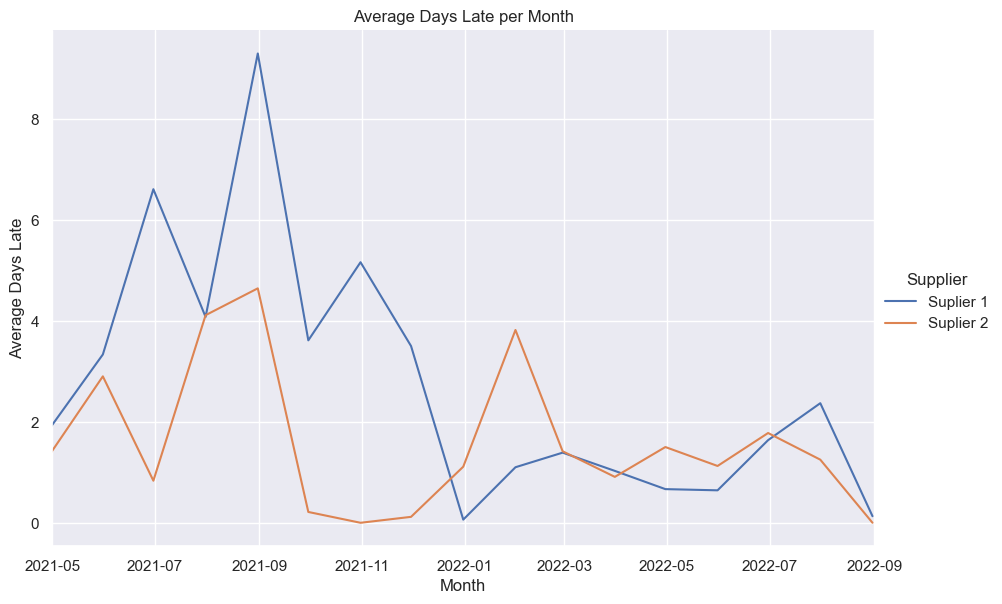

In [525]:
sns.set(style="darkgrid")
sns.relplot(
    data=new_df,
    x="Month", y="Average Days Late", hue="Supplier",
    height=6, aspect=1.5,
    kind="line",
    # row="Supplier",
).set(title="Average Days Late per Month")
plt.xlim(pd.to_datetime('2021-05-01'),pd.to_datetime('2022-09-01'))

# label points on the plot
# for x, y in zip(new_df["Month"], new_df["Average Days Late"]):
#     if x >= pd.to_datetime('2021-05-01'):
#         # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
#         plt.text(x = x, # x-coordinate position of data label
#         y = y, # y-coordinate position of data label, adjusted to be 150 below the data point
#         s = "{:.1f}".format(y), # data label, formatted to ignore decimals
#         color = "Black") # set colour of line
plt.savefig("ADL.png",bbox_inches='tight')